In [2]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

In [3]:
import cohere
co = cohere.Client("4Pyaoq0N1wP4JAe89ECvNxWobIejmcvW5Fl6w1Bt")

In [5]:
# Load the dataset to a dataframe
df_orig = pd.read_csv('./atis_intents_train.csv', names=['intent','query'])

In [6]:
# Take a small sample for illustration purposes
sample_classes = ['atis_airfare', 'atis_airline', 'atis_ground_service']
# take a handfull of sample data - unstructed 
df = df_orig.sample(frac=0.1, random_state=30) 
# only use those which has intent output one from sample_classes
df = df[df.intent.isin(sample_classes)]
# drop the shuffled index , due to sample 
df_orig = df_orig.drop(df.index)
# reset indexes
df.reset_index(drop=True,inplace=True)

In [7]:
# Remove unnecessary column 
intents = df['intent'] #save for a later need
df.drop(columns=['intent'], inplace=True)

In [8]:
''' 
Time to turn words into embeddings , we will use cohere embed endpoint 
we supply 3 params - 
     Texts - The list of texts you want to embed
     model -  The model to use to generate the embedding. At the time of writing, there are four models available:
                - embed-english-v3.0 (English)
                - embed-english-light-v3.0 (English)
                - embed-multilingual-v3.0 (Multilingual: 100+ languages)
                - embed-multilingual-light-v3.0 (Multilingual: 100+ languages)
     input_type - Specifies the type of document to be embedded. At the time of writing, there are four options:
                     - search_document: For documents against which search is performed
                     - search_query: For query documents
                     - classification: For when the embeddings will be used as an input to a text classifier
                     - clustering: For when you want to cluster the embeddings
''' 

def get_embeddings(texts, model='embed-english-v3.0', input_type="search_document"):
    output = co.embed(
        model=model,
        input_type=input_type,
        texts=texts)
    return output.embeddings

df['query_embeds'] = get_embeddings(df['query'].tolist());



In [9]:
# let's visualise embeddings using heatmap 

# but first let's compress the dimension from 1024 to 10 using PCA 
# Function to return the principal components
def get_pc(arr, n):
    pca = PCA(n_components=n)
    embeds_transform = pca.fit_transform(arr)
    return embeds_transform
  
# Reduce embeddings to 10 principal components to aid visualization
embeds = np.array(df['query_embeds'].tolist())
embeds_pc = get_pc(embeds, 10)


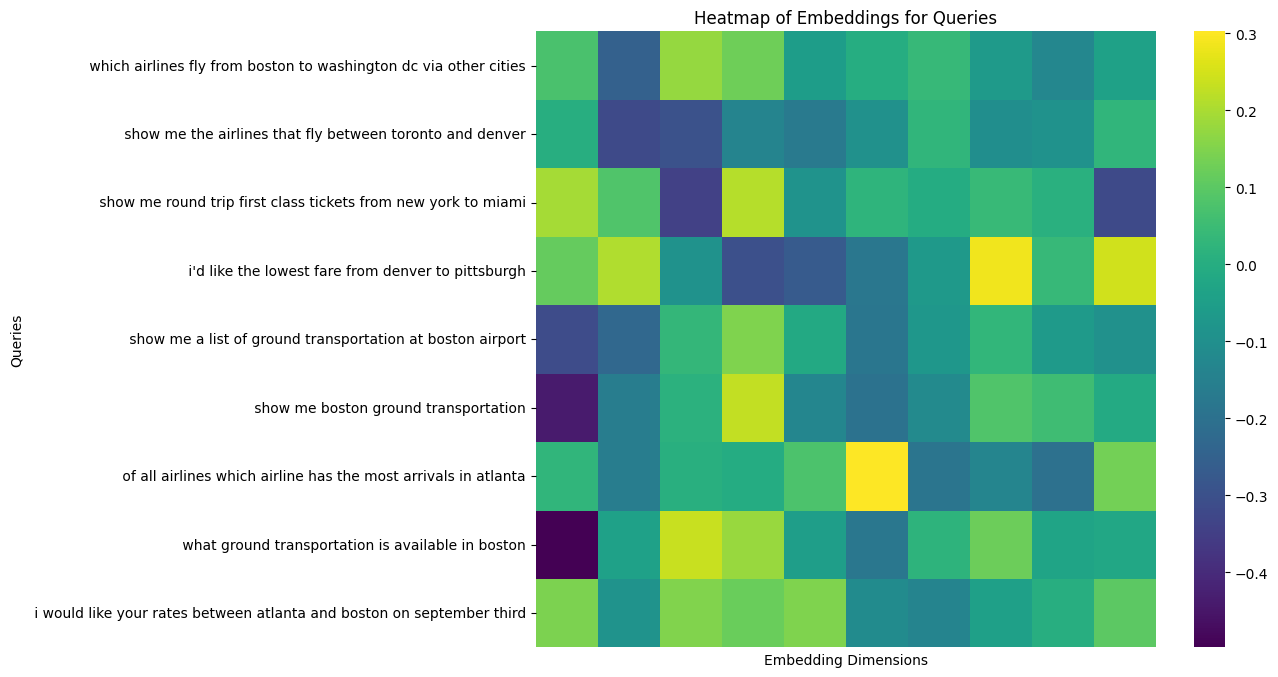

In [10]:
# now lets plot heatmap for these 10 embedding lists for 9 data points 
Ydir = df['query'].head(9).to_list() # first 9 queries 
Xdir = embeds_pc[:9]
plt.figure(figsize=(10, 8))  # Adjust the size as necessary
sns.heatmap(Xdir, annot=False, cmap='viridis', xticklabels=False, yticklabels=Ydir)

# Add labels and title for clarity
plt.xlabel("Embedding Dimensions")
plt.ylabel("Queries")
plt.title("Heatmap of Embeddings for Queries")

# Show the plot
plt.show()

In [11]:
# let's visualize embeddings on a 2D plot 


# Function to generate the 2D plot
def generate_chart(df,xcol,ycol,lbl='on',color='basic',title=''):
    chart = alt.Chart(df).mark_circle(size=500).encode(
        x=
        alt.X(xcol,
              scale=alt.Scale(zero=False),
              axis=alt.Axis(labels=False, ticks=False, domain=False)
             ),
        y=
        alt.Y(ycol,
              scale=alt.Scale(zero=False),
              axis=alt.Axis(labels=False, ticks=False, domain=False)
             ),
        color= alt.value('#333293') if color == 'basic' else color,
        tooltip=['query']
    )
    
    if lbl == 'on':
        text = chart.mark_text(align='left', baseline='middle',dx=15, size=13,color='black').encode(text='query', color= alt.value('black'))
    else:
        text = chart.mark_text(align='left', baseline='middle',dx=10).encode()
        
    result = (chart + text).configure(background="#FDF7F0").properties(
        width=800,
        height=500,
        title=title
    ).configure_legend(orient='bottom', titleFontSize=18,labelFontSize=18)
    
    return result

In [15]:

# Set sample size to visualize
sample = 10
# Reduce embeddings to 2 principal components to aid visualization
embeds_pc2 = get_pc(embeds, 2)

# Add the principal components to dataframe
df_pc2 = pd.concat([df, pd.DataFrame(embeds_pc2)], axis=1)

# Plot the 2D embeddings on a chart
df_pc2.columns = df_pc2.columns.astype(str)
generate_chart(df_pc2.iloc[:sample],'0','1',title='2D Embeddings')

alt.LayerChart(...)